In [1]:
import numpy as np
from numba import jit
from numpy.random import default_rng as rg
rng = rg(12345)
from tqdm import tqdm
%matplotlib inline

In [2]:
import torch
import torch.optim as optim

In [3]:
from FFALayer import FFALayer
import dojo
from display import*

In [24]:
#2-layer 784-800-10
class DNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.s = 28**2
        self.p = 800
        self.nl = 10
        
        self.activation = torch.nn.functional.relu
        self.prob = torch.nn.functional.softmax
        
        self.pre = lambda x : x.reshape((x.shape[0], np.prod(x.shape[1:]))).to(torch.float32)
        self.layers = torch.nn.ModuleList([torch.nn.Linear(self.s, self.p, bias=False), torch.nn.Linear(self.p, self.nl, bias=False)])
        self.post = [self.activation,self.prob]

        self.criterion = torch.nn.MSELoss()     
        
    ###############    
    def train(self, x, y, optimizer):
        outputs = self.forward(x)
        loss = self.criterion(outputs, y)
        loss.backward()
        optimizer.step()
        return loss.item()
    ###############   
    
    def forward(self, x):
        x = self.pre(x)
        for i in range(len(self.layers)):
            x = self.layers[i](x)
            x = self.post[i](x)
        return x

    def predict(self,x):
        x = self.forward(x)
        return torch.argmax(x,axis=-1)
       
#2-layer 784-800-10
#5-layer 784-300-300-300-300-300

class FFA(torch.nn.Module):
    def __init__(self, device, sizes=None, threshold=0.5, bias=False):
        if sizes is None:
            sizes = [800,10]
        super().__init__()

        self.s = 28**2
        self.nl = 10

        self.activation = torch.nn.ReLU()
        self.norm = torch.nn.functional.normalize
        self.id = torch.nn.Identity()
        self.prob = torch.nn.Softmax()


        self.device = device

        self.pre = lambda x : self.norm(x.reshape((x.shape[0], np.prod(x.shape[1:]))).to(torch.float32))
        self.sizes = [self.s,*sizes]
        self.layers = torch.nn.ModuleList([FFALayer(self.sizes[i], self.sizes[i+1], bias=bias, act=self.activation, threshold=threshold, device = self.device) for i in range(len(self.sizes)-1)])

        

    ###############                                     
    def join(self, x, y):
        """Replace the first 10 pixels of data [x] with one-hot-encoded label [y]
        """
        x_ = x.clone()
        x_[:, :self.nl] *= 0.0
        x_[range(x.shape[0]), y] = 1.0 # x.max()
        return x_
            
    # training, assumes batches of size > 1 
    def train(self, x, true_label, optimizer, minibatch_ratio=1.0, **kwargs):
        x = self.pre(x)
        nbatch = x.shape[0]
        plabel = torch.argmax(true_label,axis=-1)           # positive data
        nlabel = (torch.arange(start=1, end=self.nl, step=1, device=self.device).unsqueeze(1).reshape(nbatch,1) + plabel) % self.nl # negative data
        # nlabel = (torch.randint(low=1,high=self.nl,size=(nbatch,),device=self.device) + plabel) % self.nl # random negative data

        loss = 0.0

        # batching
        pos = self.join(x,plabel) # label addition
        neg = self.join(x,nlabel)

        # minibatching
        # a ratio of 1.0 means no minibatching 
        # minibatching makes later layers become more independent of earlier layers
        minibatch_size = int(nbatch*minibatch_ratio)
        nminibatch = nbatch // minibatch_size
        m_pos = [pos[i*minibatch_size:(i+1)*minibatch_size] for i in range(nminibatch)]
        m_neg = [neg[i*minibatch_size:(i+1)*minibatch_size] for i in range(nminibatch)]
        for layer in self.layers:
            for i in range(nminibatch):
                m_pos[i], m_neg[i], layer_loss = layer.train(m_pos[i], m_neg[i], optimizer)
                loss += layer_loss / nminibatch

        return loss

    ##############
    def forward(self, x):
        x = self.pre(x)
        assert x.device == self.device
        goodness_per_label = []
        for label in range(10):
            h = self.join(x, label)
            goodness = []
            for layer in self.layers:
                h = layer(h)
                goodness += [h.pow(2).mean(1)]
            goodness_per_label += [sum(goodness).unsqueeze(1)]
        goodness_per_label = torch.cat(goodness_per_label, 1)
        return goodness_per_label

        
    def predict(self,x):
        x = self.forward(x)
        return torch.argmax(x,1)


In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # as other apps are currently using gpu
print(device)

from keras.datasets import mnist

(train_X, train_y_idx), (test_X, test_y_idx) = mnist.load_data()
n = train_X.shape[0]
nt = test_X.shape[0]
train_X = torch.from_numpy(train_X).to(torch.float32).to(device)
test_X = torch.from_numpy(test_X).to(torch.float32).to(device)

train_y = np.zeros((n,10))
for i in range(train_y.shape[0]):
    train_y[i,train_y_idx[i]] = 1.0
train_y = torch.from_numpy(train_y).to(torch.float32).to(device)

test_y = np.zeros((nt,10))
for i in range(test_y.shape[0]):
    test_y[i,test_y_idx[i]] = 1.0
test_y = torch.from_numpy(test_y).to(torch.float32).to(device)

print('X_train: ' + str(train_X.shape))
print('Y_train: ' + str(train_y.shape))
print('X_test:  '  + str(test_X.shape))
print('Y_test:  '  + str(test_y.shape))

cuda:0


2023-01-29 10:12:12.185445: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-29 10:12:15.374462: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.7/lib64:/usr/lib/wsl/lib/:
2023-01-29 10:12:15.376689: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.7/lib64:/usr/lib/wsl/lib/:
2023-01-29 10:12:15.376702: W tensorfl

X_train: torch.Size([60000, 28, 28])
Y_train: torch.Size([60000, 10])
X_test:  torch.Size([10000, 28, 28])
Y_test:  torch.Size([10000, 10])


In [6]:
D = dojo.dojo()
D.optimizer = lambda x : optim.ASGD(x, lr=0.001) # optim.Adam(net.parameters(), lr=base_lr)

In [26]:

D.max_batch_size=train_X.shape[0]
net = DNN() # expect 1.6% error rate
net.to(device)
report = D.train(net, train_X, train_y)
ecran(net, test_X, test_y, torch.nn.MSELoss(), report)

  0%|          | 0/80 [00:00<?, ?it/s]


TypeError: train() got an unexpected keyword argument 'start_batch_size'

100%|██████████| 80/80 [00:55<00:00,  1.45it/s]


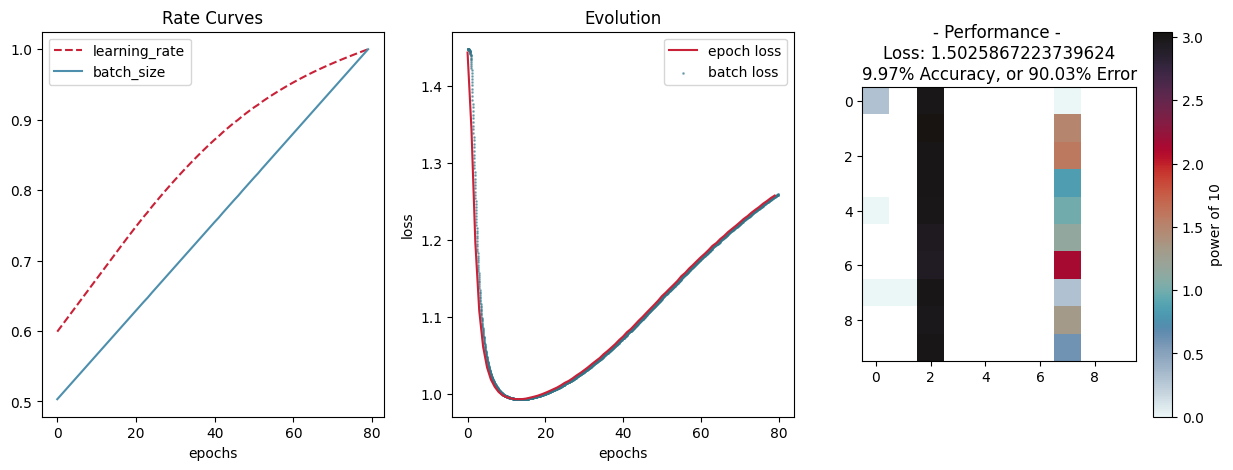

In [36]:
D.max_batch_size=3200
D.epochs=80
D.optimizer = lambda x : optim.ASGD(x, lr=1e-3, t0=10) # optim.Adam(net.parameters(), lr=base_lr
net = FFA(device,bias=True) # expect 1.6% error rate
net.to(device)
report = D.train(net,train_X, train_y,start_batch_size=1600,splits=[.0,.2])
ecran(net, test_X, test_y, torch.nn.MSELoss(), report)